In [21]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation

%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import os
import seaborn as sns
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')
import pims
import pySPM as spm 
import trackpy as tp
import glob
from sxmreader import SXMReader

In [235]:
n_range = range(186, 201)
N = len(n_range)
SXM_PATH = ["electromigration_14/Image_{0:03}.sxm".format(i) for i in n_range]
frames = SXMReader(SXM_PATH)
molecule_size = 11
min_mass = 1
max_mass = 10000
min_size = 1
max_ecc = 1
separation = 5
searchRange = 25

In [236]:
# from skimage.feature import register_translation
# from skimage.transform import AffineTransform, warp

# def shift(image, vector):
#     transform = AffineTransform(translation=vector)
#     shifted = warp(image, transform, mode='edge', preserve_range=True)
#     return shifted

In [237]:
# frames_1 = []
# for i in range(0, len(frames)):
# #     s, _, _ = register_translation(frames[0], frames[i])
# #     frames_1.append(shift(frames[i], s))
# #     print(s)
#     frames_1.append(frames[i][:, :])
# # frames_1[0] = frames_1[0][::-1,:]
f = tp.batch(frames[:], molecule_size, minmass=min_mass, separation=separation)
# # f = tp.batch(frames[:], molecule_size, minmass=min_mass, separation=separation)
# tp.quiet()  # Turn off progress reports for best performance

<Figure size 720x360 with 0 Axes>

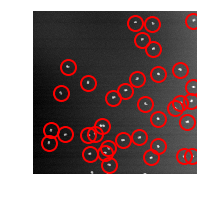

In [240]:
plt.figure()

fig=plt.figure(figsize=(4, 3))
ax1=plt.axes(xlim=(0, 256), ylim=(0, 256), frameon=False)
ln, = ax1.plot([], [], lw=3)
plt.axis('off')

def update(i):
#     tp.annotate(f[f['frame']==i], frames[i],  plot_style={'markersize': 0.5}, ax=ax1)
    tp.annotate(f[f['frame']==i], frames[i],  plot_style={'markersize': 0,5}, ax=ax1)
    for line in ax1.lines[:-1]:
        line.set_marker(None)
    return ln,

ani = FuncAnimation(fig, update, frames=range(len(frames)), interval=100)
ani

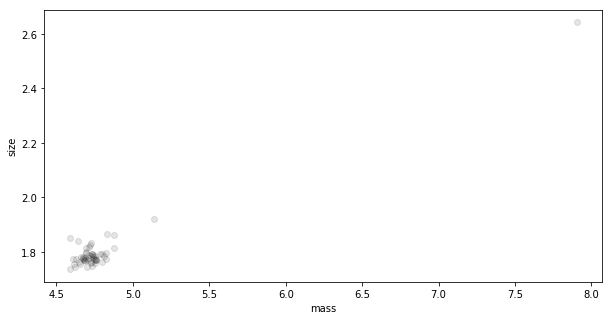

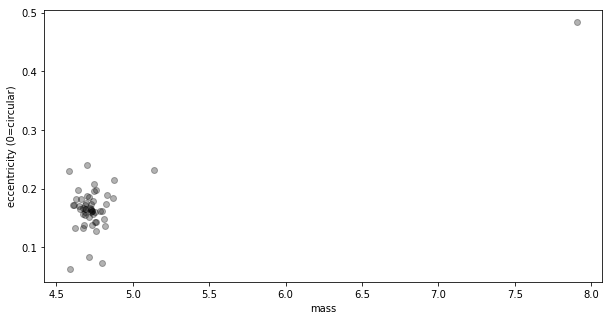

In [227]:
t = tp.link(f, search_range=searchRange, adaptive_stop=10, memory=3)
plt.figure()
tp.mass_size(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass
tp.mass_ecc(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass

In [228]:
t1 = t[((t['mass'] > min_mass) & (t['size'] > min_size) &
         (t['ecc'] < max_ecc)) & (t['mass'] < max_mass)]
t2 = tp.filter_stubs(t, 1)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t2['particle'].nunique())

Before: 53
After: 53


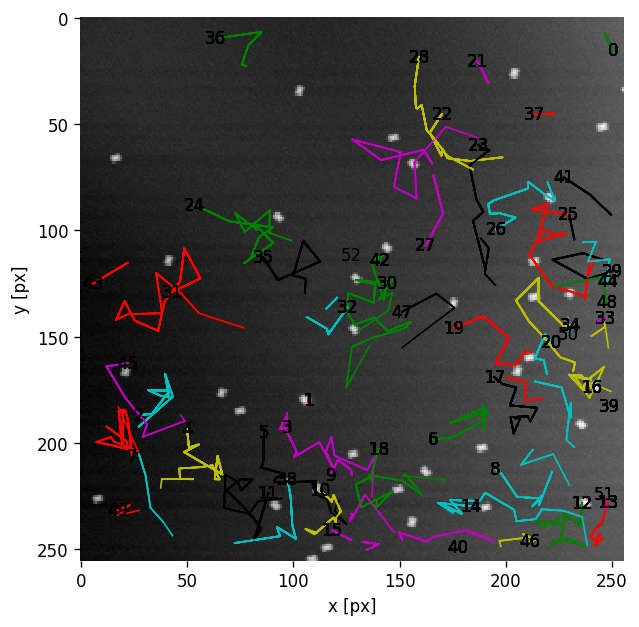

In [229]:
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

fig=plt.figure(figsize=(8, 6), dpi=120)
ax1=plt.axes(xlim=(0, 256), ylim=(0, 256), frameon=False)
# plt.axis('off')
ln, = ax1.plot([], [], lw=3)
ax1.set_prop_cycle(color=['g', 'r', 'c', 'm', 'y', 'k'])

def update(i):
#     tp.plot_traj(t2[(t2['frame']<=i)], superimpose=frames[i], label=False, ax=ax1)
    tp.plot_traj(t2[(t2['frame']<=i)], superimpose=frames_1[i], label=True, ax=ax1)
    ax1.set_prop_cycle(color=['g', 'r', 'c', 'm', 'y', 'k'])
    return ln,

ani = FuncAnimation(fig, update, frames=range(len(frames)), interval=1000)
ani

(-0.08732296767293865, 3.070842850552706)

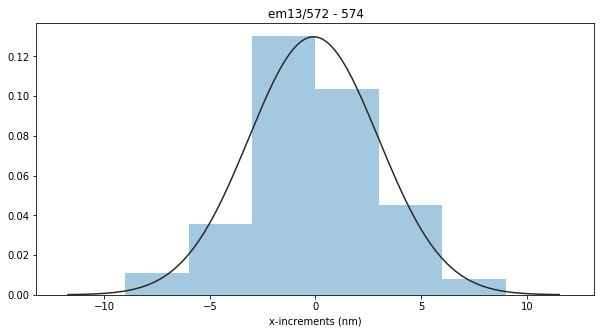

In [230]:
from scipy.stats import norm
d = tp.compute_drift(t2)
t3 = tp.subtract_drift(t2.copy(), d) * NM_PER_PIXEL
t3 = t3.drop(columns='frame').reset_index()
t3['x_inc'] = t3.groupby('particle')['x'].diff()
t3 = t3[~t3['x_inc'].isna()]

sns.distplot(t3.x_inc, fit=norm, norm_hist=False, bins=np.arange(-12, 14, 3), kde=False)
plt.xlabel("x-increments (nm)")
plt.title("em13/572 - 574")
norm.fit(t3.x_inc)

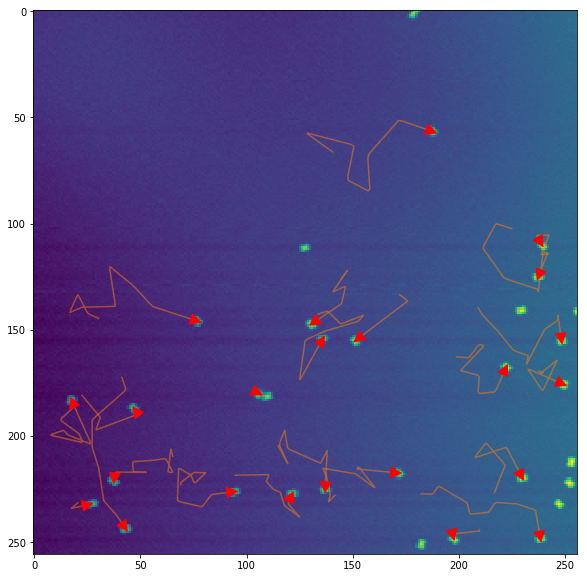

In [234]:
from scipy import interpolate 
plt.figure(figsize=(10, 10))

def spline_fit(df):
    x = df.x
    y = df.y
    tck,u=interpolate.splprep([x,y],s=0.0, k=1)
    x_i,y_i= interpolate.splev(np.linspace(0,1,100),tck)
    line = plt.plot(x_i[-60:], y_i[-60:], alpha=0.5, color='tab:orange')[0]
    plt.arrow(x_i[-1],y_i[-1],x_i[-1]-x_i[-2], y_i[-1]-y_i[-2], 
    shape='full', color='r', length_includes_head=True, 
    zorder=9, head_length=5, head_width=5,)

END = 14
tmp = t2.groupby('particle').filter(lambda x: (x['frame'] == END).any()).set_index('particle')
tmp = tmp[tmp.frame <=END]
tmp.groupby('particle').filter(lambda x: len(x) > 3).groupby('particle').apply(spline_fit)
plt.imshow(frames[END])

In [95]:
d = tp.compute_drift(t2)
t3 = tp.subtract_drift(t2.copy(), d)
# print(d)

In [96]:
NM_PER_PIXEL = frames.meters_per_pixel * 1e9

bad: [1, 2, 3, 4, 5, 9, 10, 1, 2, 3, 4, 5, 9, 10]
good: [6, 7, 8, 12, 13, 14, 6, 7, 8, 12, 13, 14]


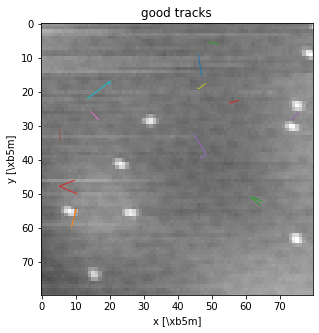

                     1          2          3          4          5         6   \
lag time [s]                                                                    
1.0           15.358036  12.828559  27.301921  25.580746   5.011683  4.429143   
2.0           19.606194   1.730855  16.218872  51.964511  11.685791  9.825656   

                    7         8          9          10        12        13  \
lag time [s]                                                                 
1.0           4.210036  2.714215  36.263041  17.676462  6.347006  3.097915   
2.0           7.687365  6.391282  58.865414  33.027470       NaN  7.506056   

                    14  
lag time [s]            
1.0           8.525616  
2.0                NaN  


In [370]:
good_particles = []
bad_particles = []
t4 = t3.groupby('particle').filter(lambda x: len(x) >= 2)
paths = []
def is_track_good(track):
    global displacements
    x = track['x'].values
    y = track['y'].values
    denan = lambda x: x[~np.isnan(x)]
    x = denan(x) 
    y = denan(y) 
    pos = np.array([x,y]).T
    delta = pos[1:]-pos[:-1]
    mean_square = np.einsum("ij, ij->i", delta, delta)
    good = np.max(mean_square) < (3e-9/frames.meters_per_pixel)**2
    (good_particles if good else bad_particles).append(track['particle'].values[0])
    if(good):
        paths.append(delta)
    return good 
movement_filter = t4.groupby('particle').apply(is_track_good).values
tm = t4.groupby('particle').filter(is_track_good)
tm = t3
print("bad:", bad_particles)
plt.figure()
plt.title("bad tracks")
# tp.plot_traj(t4.groupby('particle').filter(lambda x: not is_track_good(x)), mpp=(frames.meters_per_pixel*1e6), superimpose=frames[0]);
print("good:", good_particles)
plt.title("good tracks")
tp.plot_traj(tm, mpp=(frames.meters_per_pixel*1e9), superimpose=frames[0]);
im = tp.imsd(tm, 1e9*frames.meters_per_pixel, 1)  # microns per pixel = 100/285., frames per second = 24
# im = im.T[movement_filter].T 
print(im)

The mean square displacement is:  4.377523919850854 nm


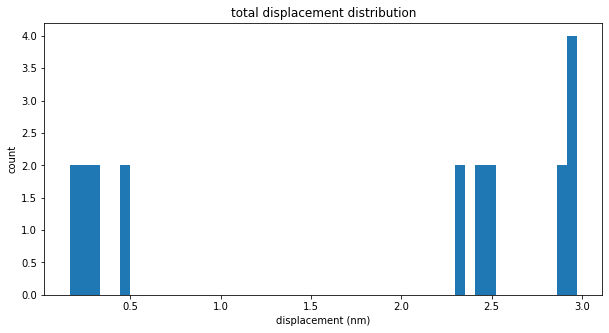

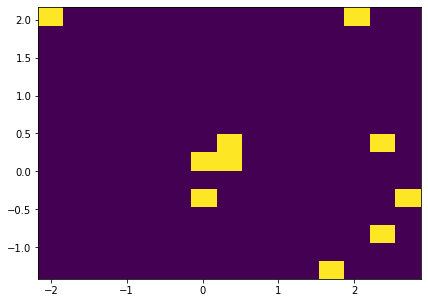

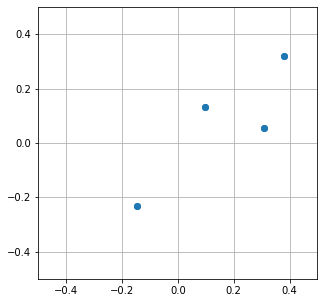

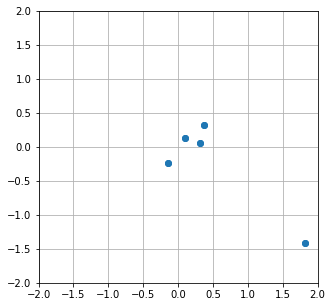

In [372]:
displacements = np.concatenate(paths)*frames.meters_per_pixel*1e9
dists = np.sqrt(np.einsum("ij, ij->i", displacements, displacements))
print("The mean square displacement is: ", (dists**2).mean(), "nm")
plt.title("total displacement distribution")
plt.xlabel("displacement (nm)")
plt.ylabel("count")
plt.hist(dists, bins=50);
fig, ax = plt.subplots()
ax.set_aspect('equal', 'box')
ax.hist2d(displacements.T[0], displacements.T[1], bins = 15);
plt.figure(figsize=(5,5));
import seaborn as sns
displacement_df = pd.DataFrame(displacements, columns=['dx','dy'])
#g = sns.jointplot(x="dx", y="dy", data=displacement_df)
plt.scatter(displacement_df['dx'],displacement_df['dy'])
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.grid()
ax.set_aspect('equal', 'box')
plt.figure(figsize=(5,5));
plt.scatter(displacement_df['dx'],displacement_df['dy'])
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.grid()
ax.set_aspect('equal', 'box')

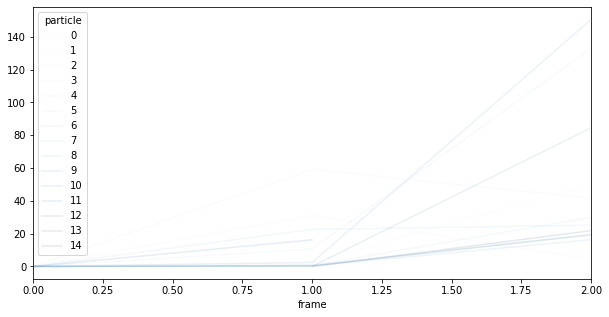

In [373]:
def msd(df):
    dis_x = df.x - df.x.iloc[0]
    dis_y = df.y - df.y.iloc[0]
    return dis_x **2 + dis_y ** 2
msds = tm.groupby('particle').apply(msd)
ax = msds.unstack(level=0).plot(kind='line', alpha=0.1, colormap='Blues')

In [376]:
em.index

Float64Index([1.0, 2.0], dtype='float64', name='lagt')

6.917612495482581

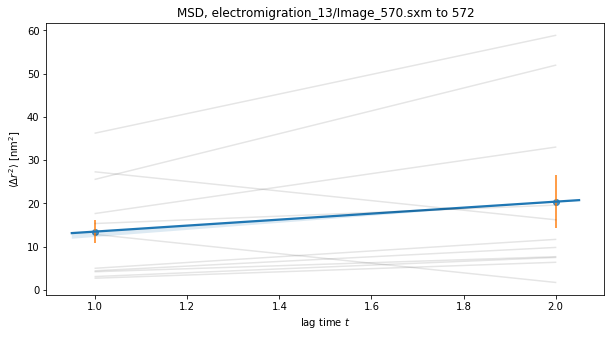

In [374]:
# bl = tp.is_typical(im, 10, 0, 0.9)
# typical_tm = tm[tm.particle.isin(bl.index[bl].tolist())]
im = tp.imsd(tm, 1e9*frames.meters_per_pixel, 1)  # microns per pixel = 100/285., frames per second = 24
em = tp.emsd(tm, frames.meters_per_pixel*1e9, 1, max_lagtime=10) # microns per pixel = 100/285., frames per second = 24
N = tp.emsd(tm, frames.meters_per_pixel*1e9, 1, detail=True, max_lagtime=10).set_index('lagt').N
ax = sns.regplot(em.index.values, em)
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [nm$^2$]',
       xlabel='lag time $t$')
ax.errorbar(em.index.values, em, yerr=em / np.sqrt(N), ls='none')
#ax.set(ylim=(1e-2, 10));
plt.title("MSD, " + SXM_PATH[0] + " to {}".format(n_range[-1]))
# frame_id = 0
# filename = frames.filenames[frame_id]
# base_path = filename[:filename.find('/')]
# path = os.path.join("output", base_path)
# if not os.path.exists(path):
#     os.makedirs(path)
# fig.savefig(os.path.join(path, 'diffusion.png'))
# tmp = t4[t4['particle'] == 0] * frames.meters_per_pixel*1e6
# r2 = (tmp.x - tmp.iloc[0].x) ** 2 + (tmp.y - tmp.iloc[0].y)**2
# plt.plot(r2)
from scipy.stats import linregress
result, _, _, _, _ = linregress(em.index, em)
result
# result = tp.utils.fit_powerlaw(em)  # performs linear best fit in log space, plots]
# print(result['A'])
# print(result['n'])

In [ ]:
result

In [ ]:
fig=plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$');
plt.title("MSD, " + SXM_PATH[0] + " to {}".format(n_range[-1]))
tp.utils.fit_powerlaw(em)  # performs linear best fit in log space, plots]

In [ ]:
from scipy.stats import norm
displacements = np.concatenate(paths)*frames.meters_per_pixel*1e9
dists = np.sqrt(np.einsum("ij, ij->i", displacements, displacements))
print("The mean square displacement is: ", (dists**2).mean(), "nm")
plt.title("total displacement distribution")
plt.xlabel("displacement (nm)")
plt.ylabel("count")
sns.distplot(dists, fit=norm, kde=False, bins=50);
fig, ax = plt.subplots()
ax.set_aspect('equal', 'box')
ax.hist2d(displacements.T[0], displacements.T[1], bins = 15);
plt.figure(figsize=(5,5));
import seaborn as sns
displacement_df = pd.DataFrame(displacements, columns=['dx','dy'])
#g = sns.jointplot(x="dx", y="dy", data=displacement_df)
plt.scatter(displacement_df['dx'],displacement_df['dy'])
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.grid()
ax.set_aspect('equal', 'box')
plt.figure(figsize=(5,5));
plt.scatter(displacement_df['dx'],displacement_df['dy'])
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.grid()
plt.title('{} to {}'.format(SXM_PATH[0], n_range[-1]))
ax.set_aspect('equal', 'box')

## Experimenting : DONT USE

In [ ]:
# A new version of tp.motion.emsd() that calculates standard deviation.
# This function is copied from trackpy. (Please see the trackpy license.)
# I [Viva] added the calculation of biased weighted standard deviation.

def my_emsd(traj, mpp, fps, max_lagtime=100, detail=False, pos_columns=None):
    """Compute the ensemble mean squared displacements of many particles.

    Parameters
    ----------
    traj : DataFrame of trajectories of multiple particles, including
        columns particle, frame, x, and y
    mpp : microns per pixel
    fps : frames per second
    max_lagtime : intervals of frames out to which MSD is computed
        Default: 100
    detail : Set to True to include <x>, <y>, <x^2>, <y^2>. Returns
        only <r^2> by default.

    Returns
    -------
    Series[msd, index=t] or, if detail=True,
    DataFrame([<x>, <y>, <x^2>, <y^2>, msd, N, lagt,
               std_<x>, std_<y>, std_<x^2>, std_<y^2>, 
               std_msd],
              index=frame)

    Notes
    -----
    Input units are pixels and frames. Output units are microns and seconds.
    """
    ids = []
    msds = []
    for pid, ptraj in traj.reset_index(drop=True).groupby('particle'):
        msds.append(tp.motion.msd(ptraj, mpp, fps, max_lagtime, True, pos_columns))
        ids.append(pid)
    msds = pd.concat(msds, keys=ids, names=['particle', 'frame'])
    results = msds.mul(msds['N'], axis=0).mean(level=1)  # weighted average
    results = results.div(msds['N'].mean(level=1), axis=0)  # weights normalized
    # Above, lagt is lumped in with the rest for simplicity and speed.
    # Here, rebuild it from the frame index.
    
    if not detail:
        return results.set_index('lagt')['msd']

    # Calculation of biased weighted standard deviation
    numerator = ((msds.subtract(results))**2).mul(msds['N'], axis=0).sum(level=1)
    denominator = msds['N'].sum(level=1) # without Bessel's correction
    variance = numerator.div(denominator, axis=0)
    variance = variance[['<x>', '<y>', '<x^2>','<y^2>','msd']]
    std = np.sqrt(variance)
    std.columns = 'std_' + std.columns  

    return results.join(std)

detailed_emsd = my_emsd(tm, frames.meters_per_pixel*1e6, 1, detail=True, max_lagtime=500)

In [ ]:
import matplotlib
plt.errorbar(detailed_emsd.lagt, 
             detailed_emsd.msd, 
             yerr = detailed_emsd.std_msd, 
             capthick=0, 
             alpha = 0.7,
             linewidth=.2,
             label="biased weighted standard deviation")
ax2 = plt.subplot(111)
ax2.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]', xlabel='lag time $\Delta t$ [s]')
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))

plt.legend(loc=2, fontsize='medium')